<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
import copy
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [3]:
# Uploads and defines transformations for selected files
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving temple.jpg to temple.jpg

Upload Style Image


Saving abstract_farmer.jpg to abstract_farmer.jpg
Content Path: <_io.BytesIO object at 0x7f2962cf3938>
Style Path: <_io.BytesIO object at 0x7f2962cf3fc0>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image


In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg19(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]


# *** NOTE: We create our style VGG network and content VGG network inside the scope() function for memory purposes, but it it outside the traning loop, so it only extracts layers
# for style and content once.

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
# Cache the outputs of the content and style layers for their respective images

# Layers we use for style and content transfer
# style_representation = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
# content_representation = ['conv4_2']



___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**

**DONE:**
* Display the style tensor and content tensor transformed back to an image


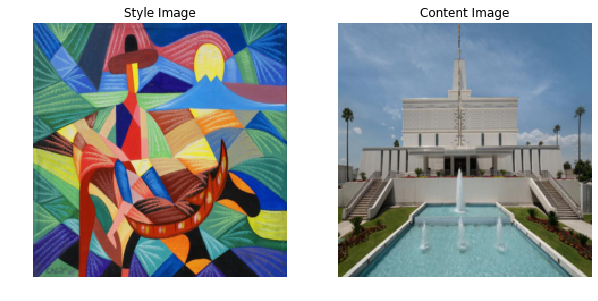

In [53]:
# Function that will display a tensor as an image
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

# Display the Style and Content Tensors as an image
plt.rcParams['figure.figsize'] = 10,7
plt.subplot(1,2,1)
plt.axis('off')
display(style_image, title='Style Image')

plt.subplot(1,2,2)
plt.axis('off')
display(content_image, title='Content Image')


___

### Part 3
Create a classes for the style and content loss

**TODO:**

**DONE:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [0]:
def gram_matrix(input):
  # Get the dimensions of the input tensor
  # batch size, num. of feature maps, dimensions of feature map (h*w)
  b, c, h, w = input.size()
  # Reshape the tensor to be size N_l * N_l
  reshaped = input.view(c * b, h * w)
  # Multiply the matrices together and divide by the total number of pixels of the feature map
  features = torch.mm(reshaped, reshaped.t()) / (b * c * h *w)
  return features
  
  
class ContentLoss(nn.Module):
  def __init__(self, target):
    """Takes in the desired target content as a tensor"""
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    """
    Compares the input image to the content image and computes the loss by doing the 
    element-wise mean squared error
    """
    content_loss = torch.nn.functional.mse_loss(input, self.target)
    return content_loss
    
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    # Create a target for each layer that we are trying to learn style
    self.target = dict()
    self.target = gram_matrix(target).detach()

  def forward(self, input):
    """ Compute the gram matrix statistics of our current image and compute the 
    Mean Squared Error between our statistics and the style image statistics for
    the given layer"""
    # Compute the gram matrix of the input
    GM = gram_matrix(input)
    # Compare the style representation of the input image to the target image
    style_loss = torch.nn.functional.mse_loss(GM, self.target)
    return style_loss


# NOTE: We Initialize our modules in the scope() function to save memory, but outside the training loop so it only happens once

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



In [66]:
def scope():
  # Run the optimizer on the images to change the image
  # using the loss of the style and content layers
  # to backpropagate errors 
  # Show the image
  
     
  # Start with a copy of the content image
  input_image = content_image.clone()

  # Initialize the loss functions and optimizer
  optimizer = optim.Adam([input_image.requires_grad_()], lr=0.1)

  # Save the style image statistics for computing style loss
  requested_style_vals = [0, 5, 10, 17, 24] 
  vgg_style_model = VGGIntermediate(requested = requested_style_vals).cuda()
  style_statistics = vgg_style_model.forward(style_image)

  # Save the content image statistics for computing content loss
  requested_content_vals = [5] #
  vgg_content_model = VGGIntermediate(requested = requested_content_vals).cuda()
  content_statistics = vgg_content_model.forward(content_image)

  # Instantiate a content loss module for each content layer 
  #  with the content reference image outputs for that layer for comparison
  content_losses = {}
  content_losses[5] = ContentLoss(content_statistics[5])

  # Instantiate a style loss module for each style layer 
  #  with the style reference image outputs for that layer for comparison
  style_losses = {}
  for key in style_statistics.keys():
    style_losses[key] = StyleLoss(style_statistics[key])
        
  num_epochs = 500
  # loop = tqdm(total=len(range(num_epochs)), position = 0)

  gc.collect()

  alpha = 1e5
  beta = 1
  image_sequence = []
  image_sequence.append(input_image.clone())

  for epoch in range(num_epochs):    
    # Make sure image values are between 0 and 1
    input_image.data.clamp_(0, 1) 
    image_sequence.append(input_image.clone())
    optimizer.zero_grad()

    # Compute the current statistics of the generated image
    current_style = vgg_style_model.forward(input_image)
    current_content = vgg_content_model.forward(input_image)

    # Initialize the total loss
    total_content_loss = 0
    total_style_loss = 0

    # Compute the loss for the content image
    for key in content_losses.keys():
      total_content_loss += content_losses[key].forward(current_content[key])

    # Compute the loss for the style image
    for key in style_losses.keys():
      total_style_loss += style_losses[key].forward(current_style[key])
      
    # Sum the losses, display every 50 steps, and backpropogate
    loss = alpha*total_style_loss + beta*total_content_loss

    if epoch % 50 == 0:
      print('Epoch:{}, Content Loss:{:.4f}, Style Loss:{:.4f}'.format(epoch, total_content_loss, 1e5*total_style_loss))

    loss.backward()
    optimizer.step()


    # loop.update(1)

  input_image.data.clamp_(0, 1) 
  return input_image, image_sequence
        
optimized_image, image_sequence = scope()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch:0, Content Loss:0.0000, Style Loss:3179.4995
Epoch:50, Content Loss:17.2294, Style Loss:90.3807
Epoch:100, Content Loss:15.3671, Style Loss:23.8872
Epoch:150, Content Loss:14.5001, Style Loss:15.5798
Epoch:200, Content Loss:13.9005, Style Loss:12.4013
Epoch:250, Content Loss:17.2243, Style Loss:92.2562
Epoch:300, Content Loss:14.8848, Style Loss:18.4855
Epoch:350, Content Loss:13.3849, Style Loss:8.2770
Epoch:400, Content Loss:12.7761, Style Loss:7.4567
Epoch:450, Content Loss:17.4461, Style Loss:79.5169


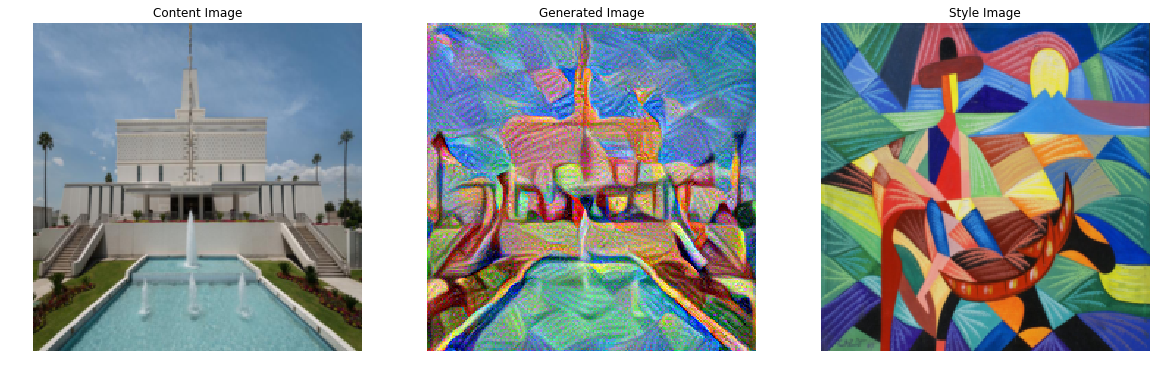

In [54]:
# Display the Content Image, Generated Image, and the Style Image all Together
plt.rcParams['figure.figsize'] = 20,14
plt.subplot(1,3,1)
plt.axis('off')
display(content_image, "Content Image")

plt.subplot(1,3,2)
plt.axis('off')
display(optimized_image, "Generated Image")

plt.subplot(1,3,3)
plt.axis('off')
display(style_image, "Style Image")

### Part 5

**TODO:**

**DONE:**
- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

(1) $L_{content}(p,x,l)=\frac{1}{2}$$\sum_{i,j}(F^l_{ij} - P^l_{ij})$

This equation is how we compute the loss between the content image and the generated image. The variable $p$ represents the content image, $x$ represents the generated image, and $l$ represents the layer of the corresponding features maps. The $P^l$ represents the feature map/activations extracted at layer $l$ after passing the content image, $p$, through the VGG network, and $F^l$ represents the feature map/activations extracted from layer $l$ after passing the generated image, $x$, through the VGG network. Since these are matrices, we can compute the pixel-wise difference between these activation maps by computing the difference between each of their $(i,j)^{th}$ entries, where $i$ represents the $i^{th}$ filter in the $l^{th}$ layer of the network and $j$ represents position $j$.


(3) $G^l_{ij}=\sum_k F^l_{ik}F^l_{jk}$

This equation is how we compute a gram matrix. A gram matrix is used in computing style loss, because it is comparing the similarity of each of the filters in a given layer with the other filters in that layer to see what sorts of things are being captured by the layer (i.e. style). 

Here, $G^l_{ij}$ represents the $(i,j)^{th}$ entry of the Gram matrix computed for layer $l$. Here, $i$ and $j$ represent the index of the Feature Map extracted at layer $l$ in the VGG network. And, $\sum_k F^l_{ik}F^l_{jk}$ is the vector-vector product between the feature map at index $i$, which we write as $F^l_{i}$, and the feature map at index $j$, which we write as $F^l_{j}$. Here, $k$ goes from $0$ to $M_l$, because each $F^l_{i}$ and $F^l_{j}$ has $M_l$ entries, and is simply a placeholder variable to indicate that we are computing the dot product of $F^l_{i}$ and $F^l_{j}$,


(4) $E_l=\frac{1}{4N^2_l M^2_l}\sum_{ij}(G^l_{ij}-A^l_{ij})^2$

This equation is how we compute the style loss, represented by $E_{l}$, at a given layer, $l$, of the VGG network. The denominator has two terms, $N_{l}$, which represents number of filters in convolution layer $l$, and $M_{l}$, which represents the dimension (height * width) of the feature map produced by layer $l$. Here, $i$ and $j$ represent the index of the previous Feature Map extracted at layer $l$ in the VGG network used to compute the Gram matrices.

Next, $G^l_{ij}$ represents the $(i,j)^{th}$ entry of the style representation (Gram matrix) of the generated image, extracted at layer $l$. Similarly, $A^l_{ij}$ represents the $(i,j)^{th}$ entry of the style representation (Gram matrix) of the style image, extracted at layer $l$.
We compute, as before, the sum of the squared pixel-wise differences. But, then we divide by the total number of pixels between the two images to assign an appropriate weighting to the loss.


(5) $L_{style}(a,x)= \sum^L_{l=0}w_lE_l$

This equation is how we compute the total loss between the style image and the generated image. The variable $a$ represents the style image, and $x$ represents the generated image. $E_{l}$ represents the style loss at layer $l$ of the VGG network, which is computed using equation (4). The total style loss is computed as a sum of the style losses at each layer, $E_l$, multiplied by a weighting factor, $w_l$, which determines the contribution of each layer to the total style loss. Here, $l$ ranges from 0 to $L$, which is the index of the layer that $l$ is representing. For example, in our network, we extracted style statistics at layers 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', and 'conv5_1', which correspond to indices 0, 5, 10, 17, and 24 in the VGG19 network.